In [1]:
# Display plots directly in the notebook instead of in a new window
%matplotlib inline

# Import libraries
import numpy as np
import pandas as pd
from pandas import ExcelFile
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
import patsy
import statsmodels.api as sm
from pandas import DataFrame
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#read data from excel, set country name as index
immunerate=pd.read_excel('Measles 1st dose immunization by country.xlsx',
                         'Measles 1st dose immunization b',index_col='Country')
#developing and developed country name
developing=pd.read_excel('Measles 1st dose immunization by country.xlsx',
                         'developing countries',index_col='Country')
developed=pd.read_excel('Measles 1st dose immunization by country.xlsx',
                        'developed countries',index_col='Country')

In [3]:
#reorganizing developing immune data
#immunization rate for developing country
#merge immunication rate and developed country list
developingimmune=immunerate.merge(developing,on="Country")
developingimmune.drop(['Unnamed: 1'],axis=1,inplace=True)
developingimmune.drop(developingimmune.columns[len(developingimmune.columns)-1], 
                      axis=1, inplace=True) #drop 1980

#rearrange developing country column from 1981-2017
temp = developingimmune.columns.tolist()
developingcol = developingimmune.columns.tolist()
for i in range(len(developingcol)):
    developingcol[i]= temp[len(developingcol)-1-i]
developingimmune=developingimmune[developingcol]

In [4]:
#remove outliers in the developing countries dataset
for i in range(len(developingcol)):
    colfirst = developingimmune.iloc[:,i].quantile(q=0.25)
    colthird = developingimmune.iloc[:,i].quantile(q=0.75)
    colIQR = colthird - colfirst
    collowerbound = colfirst - colIQR
    colupperbound = colthird + colIQR
    developingimmune.iloc[:,i].where(developingimmune.iloc[:,i] > collowerbound, inplace = True)
    developingimmune.iloc[:,i].where(developingimmune.iloc[:,i] < colupperbound, inplace = True)

In [5]:
#reorganizing developed immune data
#immunization rate for developing country
#merge immunication rate and developed country list
developedimmune=immunerate.merge(developed,on='Country')
developedimmune.drop(developedimmune.columns[len(developedimmune.columns)-1], 
                     axis=1, inplace=True) #drop 1980

#rearrange developed country column from 1981-2017 (2017-1981 before rearrangement)
temp = developedimmune.columns.tolist() #save the current columns name as temp
developedcol = developedimmune.columns.tolist() #set the new columns order
for i in range(len(developedcol)):
    developedcol[i]= temp[len(developedcol)-1-i]
#rearrange the columns based on the new columns order
developedimmune=developedimmune[developedcol]

In [6]:
#remove outliers in the developing countries dataset
for i in range(len(developedcol)):
    colfirst = developedimmune.iloc[:,i].quantile(q=0.25)
    colthird = developedimmune.iloc[:,i].quantile(q=0.75)
    colIQR = colthird - colfirst
    collowerbound = colfirst - colIQR
    colupperbound = colthird + colIQR
    developedimmune.iloc[:,i].where(developedimmune.iloc[:,i] > collowerbound, inplace = True)
    developedimmune.iloc[:,i].where(developedimmune.iloc[:,i] < colupperbound, inplace = True)

In [7]:
#developed measlease outbreak data
developed = pd.read_excel('Developed.xlsx')
developed = developed.fillna(0)
developed = developed.drop(["WHO_REGION", "ISO_code", "Disease"], axis = 1)
curr = developed.columns.tolist()
outbreak = developed.columns.tolist()
for i in range(0, len(outbreak)):
    outbreak[i] = curr[len(outbreak) - 1 - i]
developed = developed[outbreak]
developed = developed.set_index(developed['Cname'])
developed = developed.drop(["Cname"], axis = 1)
developed.drop(['1980'],axis =1, inplace = True) #drop 1980

In [8]:
#developing measlse outbreak data
developing = pd.read_excel('Developing.xlsx')
developing = developing.fillna(0)
developing = developing.drop(["WHO_REGION", "ISO_code", "Disease"], axis = 1)
curr = developing.columns.tolist()
outbreak = developing.columns.tolist()
for i in range(0, len(outbreak)):
    outbreak[i] = curr[len(outbreak) - 1 - i]
developing = developing[outbreak]
developing = developing.set_index(developing['Cname'])
developing = developing.drop(["Cname"], axis = 1)
developing.drop(['1980'],axis=1,inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log
/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


developed regression: 10.7699069385 * exp( 44.9933600643 * x) + 13.9429829492
developing regression: 17.9662703404 * exp( 45.3373392706 * x) + -48.3855359387


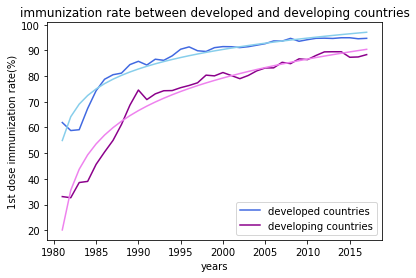

In [9]:
#take the average of immune rate for each year
developedmean=developedimmune.mean(axis=0)
developingmean=developingimmune.mean(axis=0)

#scatter plot
plt.plot(developedimmune.columns,developedmean, color= 'royalblue',label='developed countries')
plt.plot(developingimmune.columns,developingmean,color='darkmagenta',label='developing countries')
plt.title("immunization rate between developed and developing countries")
plt.ylabel('1st dose immunization rate(%)')
plt.xlabel('years')

#plot regression line
x = developedimmune.columns.tolist()
y_ed_mean= developedmean
y_ing_mean = developingmean
y_ed_reg = y_ed_mean.values
y_ing_reg = y_ing_mean.values
def exponential(x, a, b, c):
    return a * np.log(b * x) + c
xaxis = np.linspace(1,50,37)
popt_ed,pov_ed = curve_fit(exponential,xaxis,y_ed_reg)
a_ed,b_ed,c_ed = popt_ed
popt_ing,pcov_ing = curve_fit(exponential,xaxis,y_ing_reg)
a_ing,b_ing,c_ing = popt_ing

fit_ed_Data=np.array(exponential(xaxis, *popt_ed))
fit_ing_Data=np.array(exponential(xaxis, *popt_ing))

fig1 = plt.figure(1)
ax=fig1.add_subplot(1,1,1)
ax.plot(developedimmune.columns,fit_ed_Data,color= 'skyblue')
ax.plot(developedimmune.columns,fit_ing_Data,color = 'violet')
plt.legend()
print('developed regression:', a_ed,"* exp(",b_ed,'* x) +',c_ed)
print('developing regression:', a_ing,"* exp(",b_ing,'* x) +',c_ing)

In [10]:
#measles outbreak mean
developedLine = developed.mean(axis = 0)
developingLine = developing.mean(axis = 0)

r^2 =  0.803043711943
regression line: outbreak = -412.023130195 immunerate + 39779.7324443


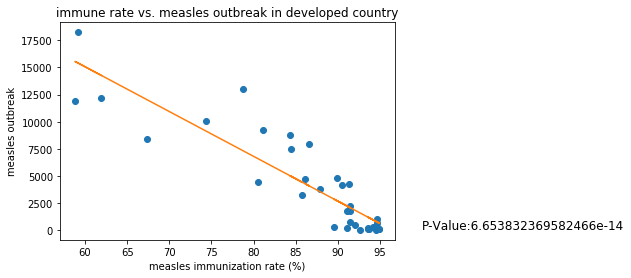

In [11]:
yed = developedLine #developed outbreak mean
xed = developedmean #developed immune mean
slope, intercept, r_value, p_value, std_err = stats.linregress(xed,yed)
line = slope*xed+intercept

plt.plot(xed,yed,'o', xed, line)
plt.title('immune rate vs. measles outbreak in developed country')
plt.ylabel('measles outbreak')
plt.xlabel('measles immunization rate (%)')
plt.text(100, 100,f"P-Value:{p_value}", size=12)
print('r^2 = ', r_value*r_value)
print('regression line: outbreak =', slope,"immunerate +", intercept)

def developed_predict (immunerate):
    predict = immunerate * slope + intercept
    return predict

r^2 =  0.95151738159
regression line: oubreak = -376.175277564 (immunerate) + 34723.3652192


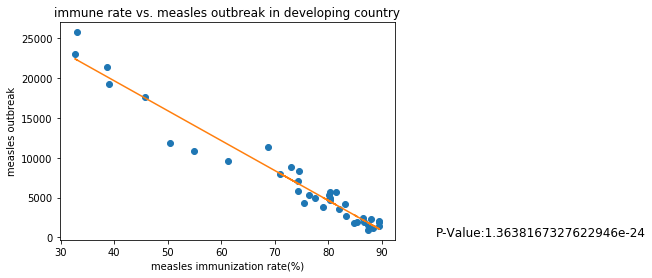

In [12]:
ying = developingLine
xing = developingmean
slope, intercept, r_value, p_value, std_err = stats.linregress(xing,ying)
line = slope*xing+intercept

plt.plot(xing,ying,'o', xing, line)
plt.ylabel('measles outbreak')
plt.xlabel('measles immunization rate(%)')
plt.title('immune rate vs. measles outbreak in developing country')
plt.text(100, 100,f"P-Value:{p_value}", size=12)
print('r^2 = ', r_value*r_value)
print('regression line: oubreak =', slope,"(immunerate) +", intercept)

def developing_predict (immunerate):
    predict = immunerate * slope + intercept
    return predict

In [13]:
developedBO = pd.read_excel('Developed.xlsx')
developedBO = developedBO.fillna(0)
developedBO = developedBO.drop(["WHO_REGION", "ISO_code", "Disease"], axis = 1)
curr = developedBO.columns.tolist()
outbreak = developedBO.columns.tolist()
for i in range(0, len(outbreak)):
    outbreak[i] = curr[len(outbreak) - 1 - i]
developedBO = developedBO[outbreak]
developedBO = developedBO.set_index(developedBO['Cname'])
developedBO = developedBO.drop(["Cname"], axis = 1)
#developed = developed.T
#developed.plot(figsize = (20,20))
#plt.xlabel('years')
#plt.ylabel('Number of Outbreaks')

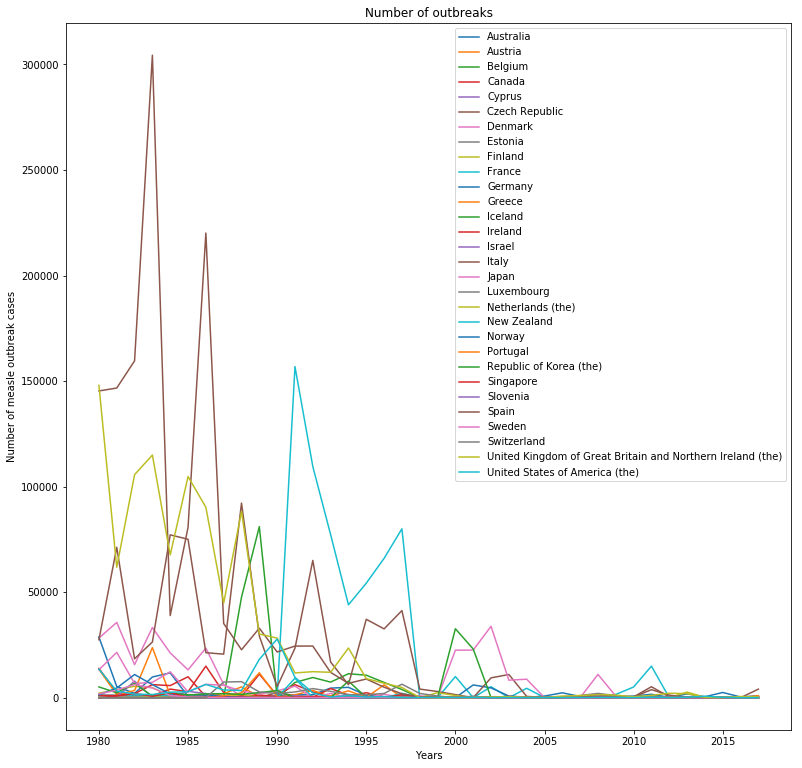

In [14]:
x_axis=[i for i in range(1980,2018)]
countries = []
plt.figure(figsize=(13,13))
for curr in developedBO.iterrows():
    info = curr[1]
    country = curr[0]
    countries.append(country)
    data =[]
    for i in range (0, len(info)):
        data.append(info[i])
    plt.plot(x_axis, data, label=country)
plt.title('Number of outbreaks', color='black') 
plt.xlabel('Years')
plt.ylabel('Number of measle outbreak cases')
plt.legend()
plt.show()

In [15]:
developingBO = pd.read_excel('Developing.xlsx')
developingBO = developingBO.fillna(0)
developingBO = developingBO.drop(["WHO_REGION", "ISO_code", "Disease"], axis = 1)
#developing = developing.T
#developing.plot(figsize = (20,20))
#plt.xlabel('years')
#plt.ylabel('Number of Outbreaks')

In [16]:
curr = developingBO.columns.tolist()
outbreak = developingBO.columns.tolist()
for i in range(0, len(outbreak)):
    outbreak[i] = curr[len(outbreak) - 1 - i]
developingBO = developingBO[outbreak]
developingBO = developingBO.set_index(developingBO['Cname'])
developingBO = developingBO.drop(["Cname"], axis = 1)
developingBO

,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
Cname,,,,,,,,,,,,,,,,,,,,,
Afghanistan,32455.0,31107.0,20320.0,18808.0,16199.0,14457.0,8107.0,10357.0,4561.0,1170.0,...,1599.0,2861.0,1989.0,3013.0,2787.0,430.0,492.0,1154.0,638.0,1511.0
Albania,0.0,0.0,3.0,17.0,0.0,0.0,0.0,0.0,0.0,136034.0,...,0.0,0.0,10.0,28.0,9.0,0.0,0.0,0.0,17.0,12.0
Algeria,15527.0,20849.0,29584.0,22126.0,22553.0,20114.0,3975.0,2500.0,2634.0,4169.0,...,217.0,107.0,103.0,112.0,18.0,25.0,0.0,63.0,41.0,112.0
Angola,29656.0,19714.0,30067.0,22589.0,22685.0,22822.0,15580.0,13368.0,21009.0,19820.0,...,265.0,2807.0,1190.0,1449.0,4458.0,8523.0,11699.0,119.0,53.0,29.0
Argentina,16102.0,17582.0,4432.0,7106.0,31751.0,9240.0,6448.0,8024.0,4751.0,4009.0,...,0.0,3.0,17.0,3.0,2.0,0.0,1.0,0.0,0.0,3.0
Armenia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,10.0,13.0,33.0,2.0,1.0
Azerbaijan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,164.0,0.0,0.0,0.0,0.0
Bangladesh,11077.0,10441.0,18116.0,9569.0,11851.0,11699.0,14352.0,13631.0,11471.0,27327.0,...,2660.0,718.0,788.0,5625.0,1986.0,237.0,289.0,240.0,972.0,4001.0
Belarus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,50.0,10.0,16.0,64.0,2.0,10.0,1.0


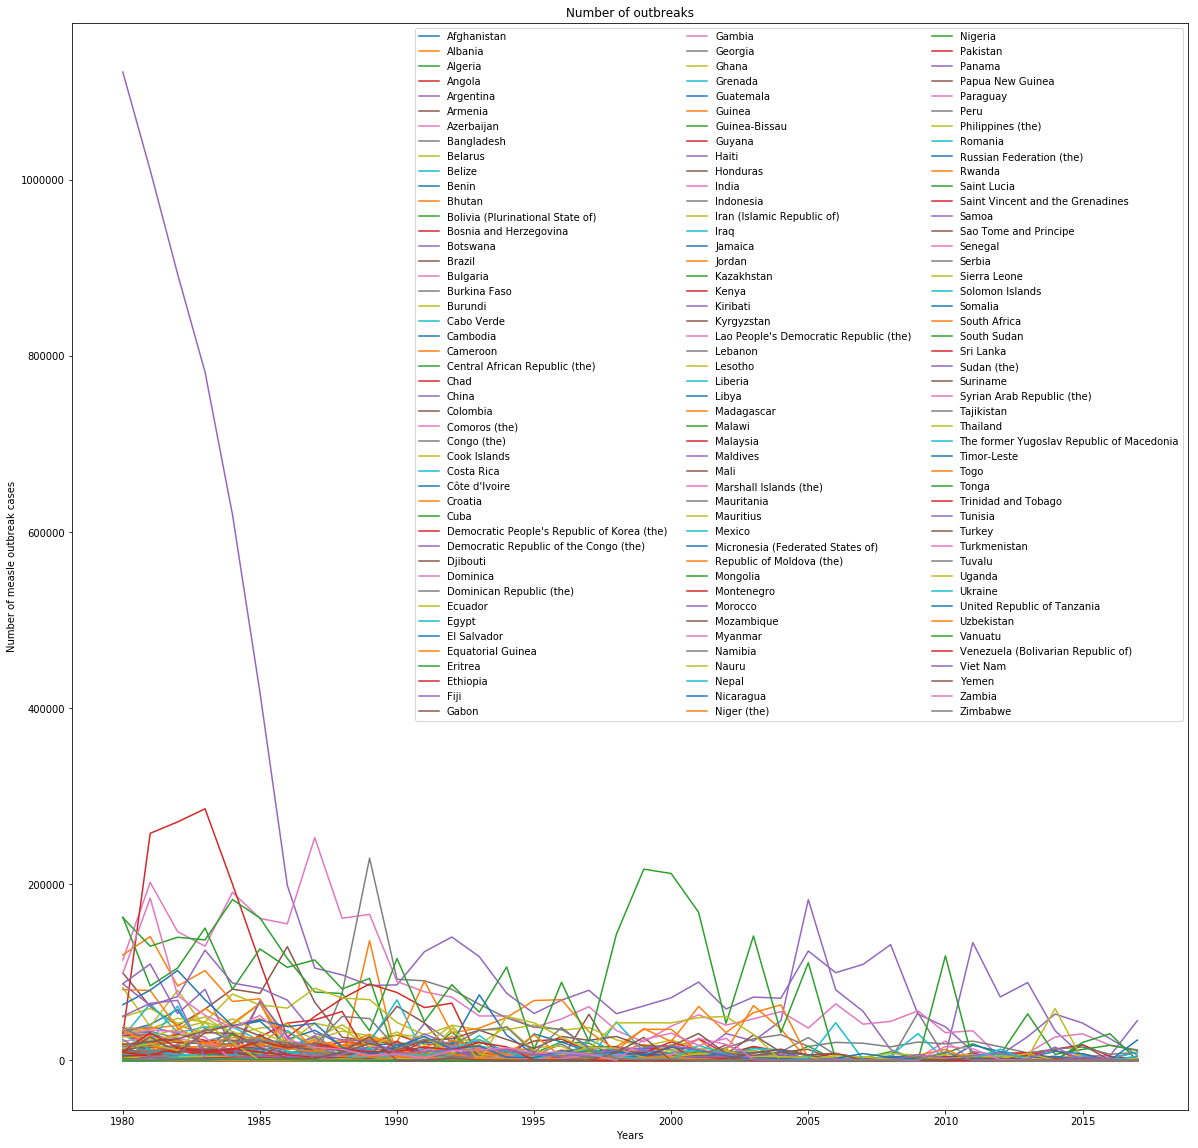

In [17]:
x_axis=[i for i in range(1980,2018)]
countries = []
plt.figure(figsize=(20,20))
for curr in developingBO.iterrows():
    info = curr[1]
    country = curr[0]
    countries.append(country)
    data =[]
    for i in range (0, len(info)):
        data.append(info[i])
    plt.plot(x_axis, data, label=country)
plt.title('Number of outbreaks', color='black') 
plt.xlabel('Years')
plt.ylabel('Number of measle outbreak cases')
plt.legend(ncol=3)
plt.show()

Text(0, 0.5, 'Number of measles oubreak')

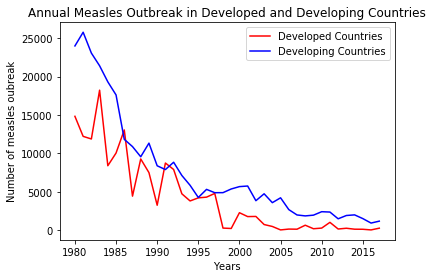

In [23]:
developedBOLine = developedBO.mean(axis = 0)
developingBOLine = developingBO.mean(axis = 0)
plt.plot(x_axis, developedBOLine, color = 'Red', label = "Developed Countries")
plt.plot(x_axis, developingBOLine, color = 'Blue', label = "Developing Countries")
plt.legend()
plt.title('Annual Measles Outbreak in Developed and Developing Countries')
plt.xlabel('Years')
plt.ylabel('Number of measles oubreak')


In [24]:
df_gdp = pd.read_excel('Annual_GDP_Rate_Change.xlsx')
for i in range(1960, 1980):
    if i in df_gdp.columns:
        del df_gdp[i]
df_gdp=df_gdp.drop(['Country Code','Indicator Name','Indicator Code'], axis=1)
df_gdp = df_gdp.fillna(0) #replace all NAN as 0

In [25]:
#List of developed coutries

developed_countries = ['Australia', 
'Austria',
'Belgium',
'Canada',
'Cyprus',
'Czech Republic',
'Denmark',
'Estonia',
'Finland',
'France',
'Germany',
'Greece',
'Iceland',
'Ireland',
'Israel',
'Italy',
'Japan',
'Luxembourg',
'Netherlands (the)',
'New Zealand',
'Norway',
'Portugal',
'Republic of Korea (the)',
'Singapore',
'Slovenia',
'Spain',
'Sweden',
'Switzerland',
'United Kingdom of Great Britain and Northern Ireland (the)',
'United States of America (the)']

#List of developing coutries

developing_countries = [
'Afghanistan',
'Albania',
'Algeria',
'Angola',
'Argentina',
'Armenia',
'Azerbaijan',
'Bangladesh',
'Belarus',
'Belize',
'Benin',
'Bhutan',
'Bolivia (Plurinational State of)',
'Bosnia and Herzegovina',
'Botswana',
'Brazil',
'Bulgaria',
'Burkina Faso',
'Burundi',
'Cabo Verde',
'Cambodia',
'Cameroon',
'Central African Republic (the)',
'Chad',
'China',
'Colombia',
'Comoros (the)',
'Congo (the)',
'Cook Islands',
'Costa Rica',
'Côte d\'Ivoire',
'Croatia',
'Cuba',
'Democratic People\'s Republic of Korea (the)',
'Democratic Republic of the Congo (the)',
'Djibouti',
'Dominica',
'Dominican Republic (the)',
'Ecuador',
'Egypt',
'El Salvador',
'Equatorial Guinea',
'Eritrea',
'Ethiopia',
'Fiji',
'Gabon',
'Gambia',
'Georgia',
'Ghana',
'Grenada',
'Guatemala',
'Guinea',
'Guinea-Bissau',
'Guyana',
'Haiti',
'Honduras',
'India',
'Indonesia',
'Iran (Islamic Republic of)',
'Iraq',
'Jamaica',
'Jordan',
'Kazakhstan',
'Kenya',
'Kiribati',
'Kyrgyzstan',
'Lao People\'s Democratic Republic (the)',
'Lebanon',
'Lesotho',
'Liberia',
'Libya',
'Madagascar',
'Malawi',
'Malaysia',
'Maldives',
'Mali',
'Marshall Islands (the)',
'Mauritania',
'Mauritius',
'Mexico',
'Micronesia (Federated States of)',
'Republic of Moldova (the)',
'Mongolia',
'Montenegro',
'Morocco',
'Mozambique',
'Myanmar',
'Namibia',
'Nauru',
'Nepal',
'Nicaragua',
'Niger (the)',
'Nigeria',
'Pakistan',
'Panama',
'Papua New Guinea',
'Paraguay',
'Peru',
'Philippines (the)',
'Romania',
'Russian Federation (the)',
'Rwanda',
'Saint Lucia',
'Saint Vincent and the Grenadines',
'Samoa',
'Sao Tome and Principe',
'Senegal',
'Serbia',
'Sierra Leone',
'Solomon Islands',
'Somalia',
'South Africa',
'South Sudan',
'Sri Lanka',
'Sudan (the)',
'Suriname',
'Syrian Arab Republic (the)',
'Tajikistan',
'Thailand',
'The former Yugoslav Republic of Macedonia',
'Timor-Leste',
'Togo',
'Tonga',
'Trinidad and Tobago',
'Tunisia',
'Turkey',
'Turkmenistan',
'Tuvalu',
'Uganda',
'Ukraine',
'United Republic of Tanzania',
'Uzbekistan',
'Vanuatu',
'Venezuela (Bolivarian Republic of)',
'Viet Nam',
'Yemen',
'Zambia',
'Zimbabwe']


<Figure size 792x432 with 0 Axes>

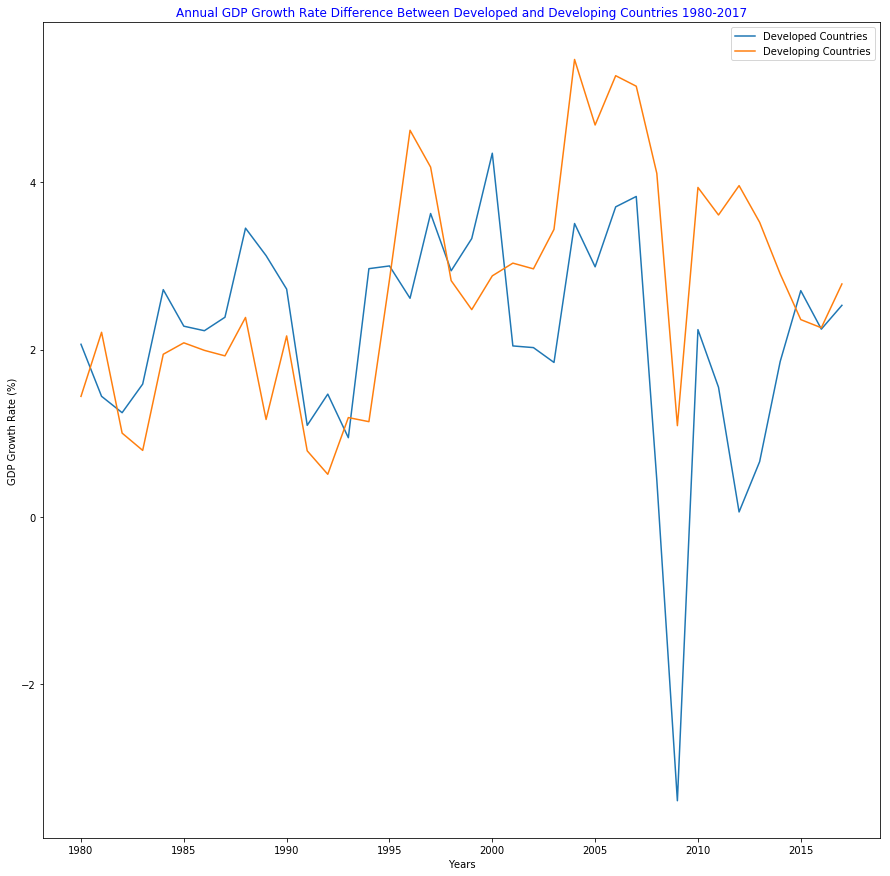

In [26]:

import matplotlib.pyplot as plt
x_axis=[i for i in range(1980,2018)]
developing_countries_gdp = {}
developed_countries_gdp = {}

i = 0

plt.figure(figsize=(11,6))
for r in df_gdp.iterrows():
    info = r[1]
    country = info[0]
    #print(country)

    if country.strip() in developed_countries:
        #print('ok')
        for i in range (1, len(info)):
            if i not in developed_countries_gdp:
                developed_countries_gdp[i] = 0
            developed_countries_gdp[i] += info[i]
    
    if country.strip() in developing_countries:
        #print('no')
        for i in range (1, len(info)):
            if i not in developing_countries_gdp:
                developing_countries_gdp[i] = 0
            developing_countries_gdp[i] += info[i]
    
        
#Now I am going to seperate them into developed and developing coutries and average them out
#So we should see two line graph that represents the average of the two group

for k in developed_countries_gdp:
    developed_countries_gdp[k] /= len(developed_countries)
    
for k in developing_countries_gdp:
    developing_countries_gdp[k] /= len(developing_countries)
       
developed_data = []
developing_data = []

for i in range(1, 39):
    developed_data.append(developed_countries_gdp[i])
    developing_data.append(developing_countries_gdp[i])
plt.figure(figsize=(15,15))
plt.plot(x_axis, developed_data, label="Developed Countries")
plt.plot(x_axis, developing_data, label="Developing Countries")
    
#print(developed_data)
plt.title('Annual GDP Growth Rate Difference Between Developed and Developing Countries 1980-2017', color='blue') 
plt.ylabel('GDP Growth Rate (%)')
plt.xlabel('Years')
plt.legend()
plt.show()


In [27]:
df_devData = pd.Series(v for v in developed_data)
type(df_devData)

pandas.core.series.Series

r^2 =  0.000700261805724
regression line: outbreak = -96.9729303518 immunerate + 4499.67940399


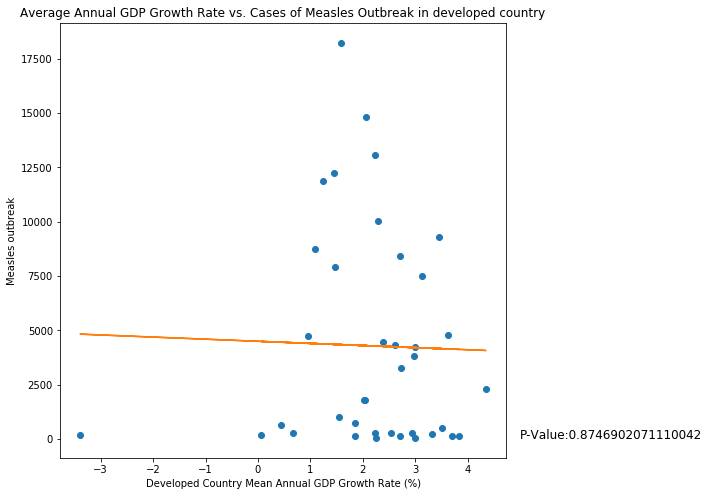

In [28]:
yed = developedBOLine #developed outbreak mean
x_ax = df_devData  #developed gdp mean
slope, intercept, r_value, p_value, std_err = stats.linregress(x_ax,yed)


line = slope*x_ax+intercept

plt.figure(figsize=(8,8))
plt.text(5, 5,f"P-Value:{p_value}", size=12)
plt.plot(x_ax,yed,'o', x_ax, line)
plt.title('Average Annual GDP Growth Rate vs. Cases of Measles Outbreak in developed country')
plt.ylabel('Measles outbreak')
plt.xlabel('Developed Country Mean Annual GDP Growth Rate (%)')
print('r^2 = ', r_value*r_value)
print('regression line: outbreak =', slope,"immunerate +", intercept)

def developed_predict (immunerate):
    predict = (immunerate * slope) + intercept
    return predict



In [29]:
#multiregression
break_out = yed.tolist()
immune = xed.tolist()
gdp = x_ax.tolist()

break_out = break_out[1:]
gdp = gdp[1:]

temp = {'BreakOut': break_out, 'ImmuneRate': immune, 'GDP': gdp}
multi = pd.DataFrame(temp)

curr = patsy.dmatrices('BreakOut ~ ImmuneRate + GDP', multi)
outcome_2 = curr[0]
predictors_2 = curr[1]
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()

In [30]:
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:               BreakOut   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     69.37
Date:                Sun, 09 Jun 2019   Prob (F-statistic):           9.99e-13
Time:                        13:35:40   Log-Likelihood:                -334.77
No. Observations:                  37   AIC:                             675.5
Df Residuals:                      34   BIC:                             680.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.971e+04   3090.736     12.849      0.0

Text(0.5, 0, 'GDP')

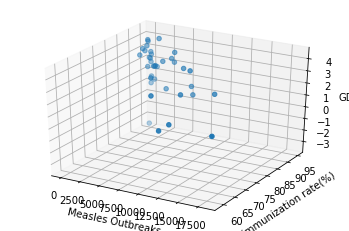

In [43]:
threedee = plt.figure().gca(projection='3d')
threedee.scatter(break_out, immune, gdp)
threedee.set_xlabel('Measles Outbreaks')
threedee.set_ylabel('immunization rate(%)')
threedee.set_zlabel('GDP')

<Figure size 432x288 with 0 Axes>

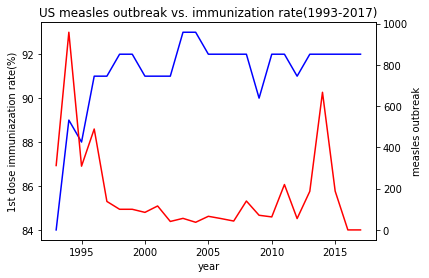

In [51]:
#us last 25 years data
us_recent_immune = developedimmune
us_recent_immune.drop(us_recent_immune.columns[0:len(us_recent_immune.columns)-25], 
                      axis=1, inplace=True)
us_recent_outbreak = developed
us_recent_outbreak.drop(us_recent_outbreak.columns[0:len(us_recent_outbreak.columns)-25], 
                      axis=1, inplace=True)
us_recent_outbreak

#scatter plot for us for most recent 25 years
fig1 = plt.figure(1)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
ax1.plot(us_recent_immune.columns,us_recent_immune.loc['United States of America'],label = 'immunization rate',color= 'b')
ax2.plot(us_recent_immune.columns,us_recent_outbreak.loc['United States of America (the)'],label = 'measles outbreak',color= 'r')
ax1.set_xlabel('year')
ax1.set_ylabel("1st dose immuniazation rate(%)")
ax2.set_ylabel('measles outbreak')
ax1.title.set_text('US measles outbreak vs. immunization rate(1993-2017)')

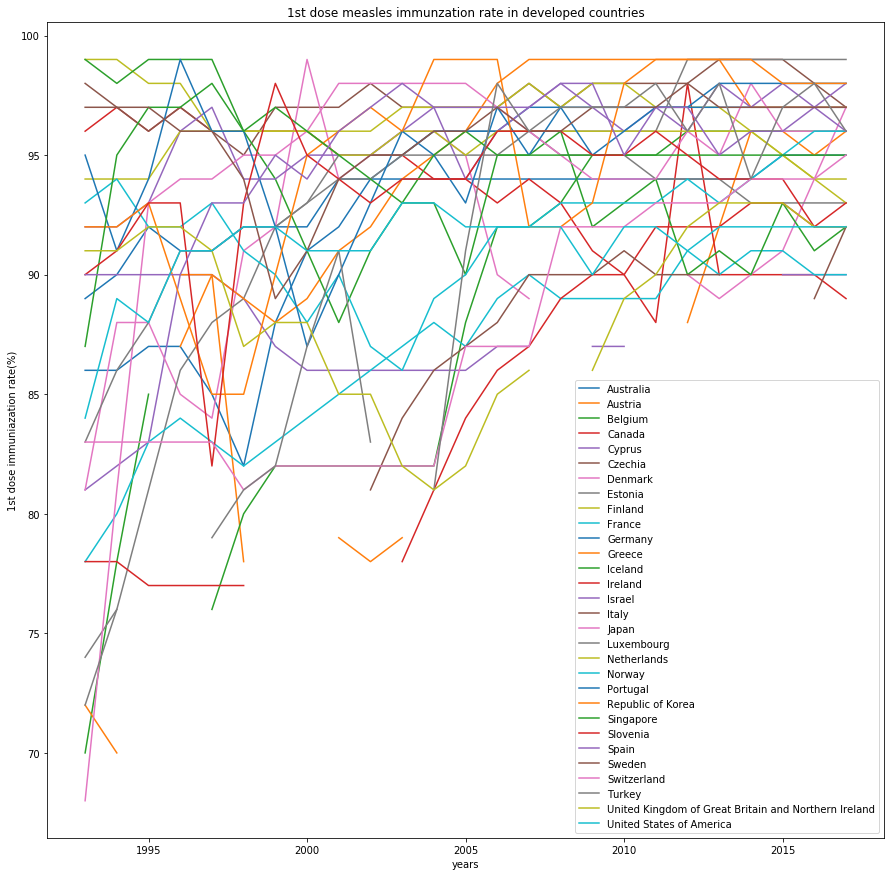

In [47]:
#really messy graph
#scatter plot for developed countries
developedimmune.T.plot(figsize=(15,15))
plt.ylabel('1st dose immuniazation rate(%)')
plt.xlabel('years')
plt.title('1st dose measles immunzation rate in developed countries')
plt.legend (loc=4)

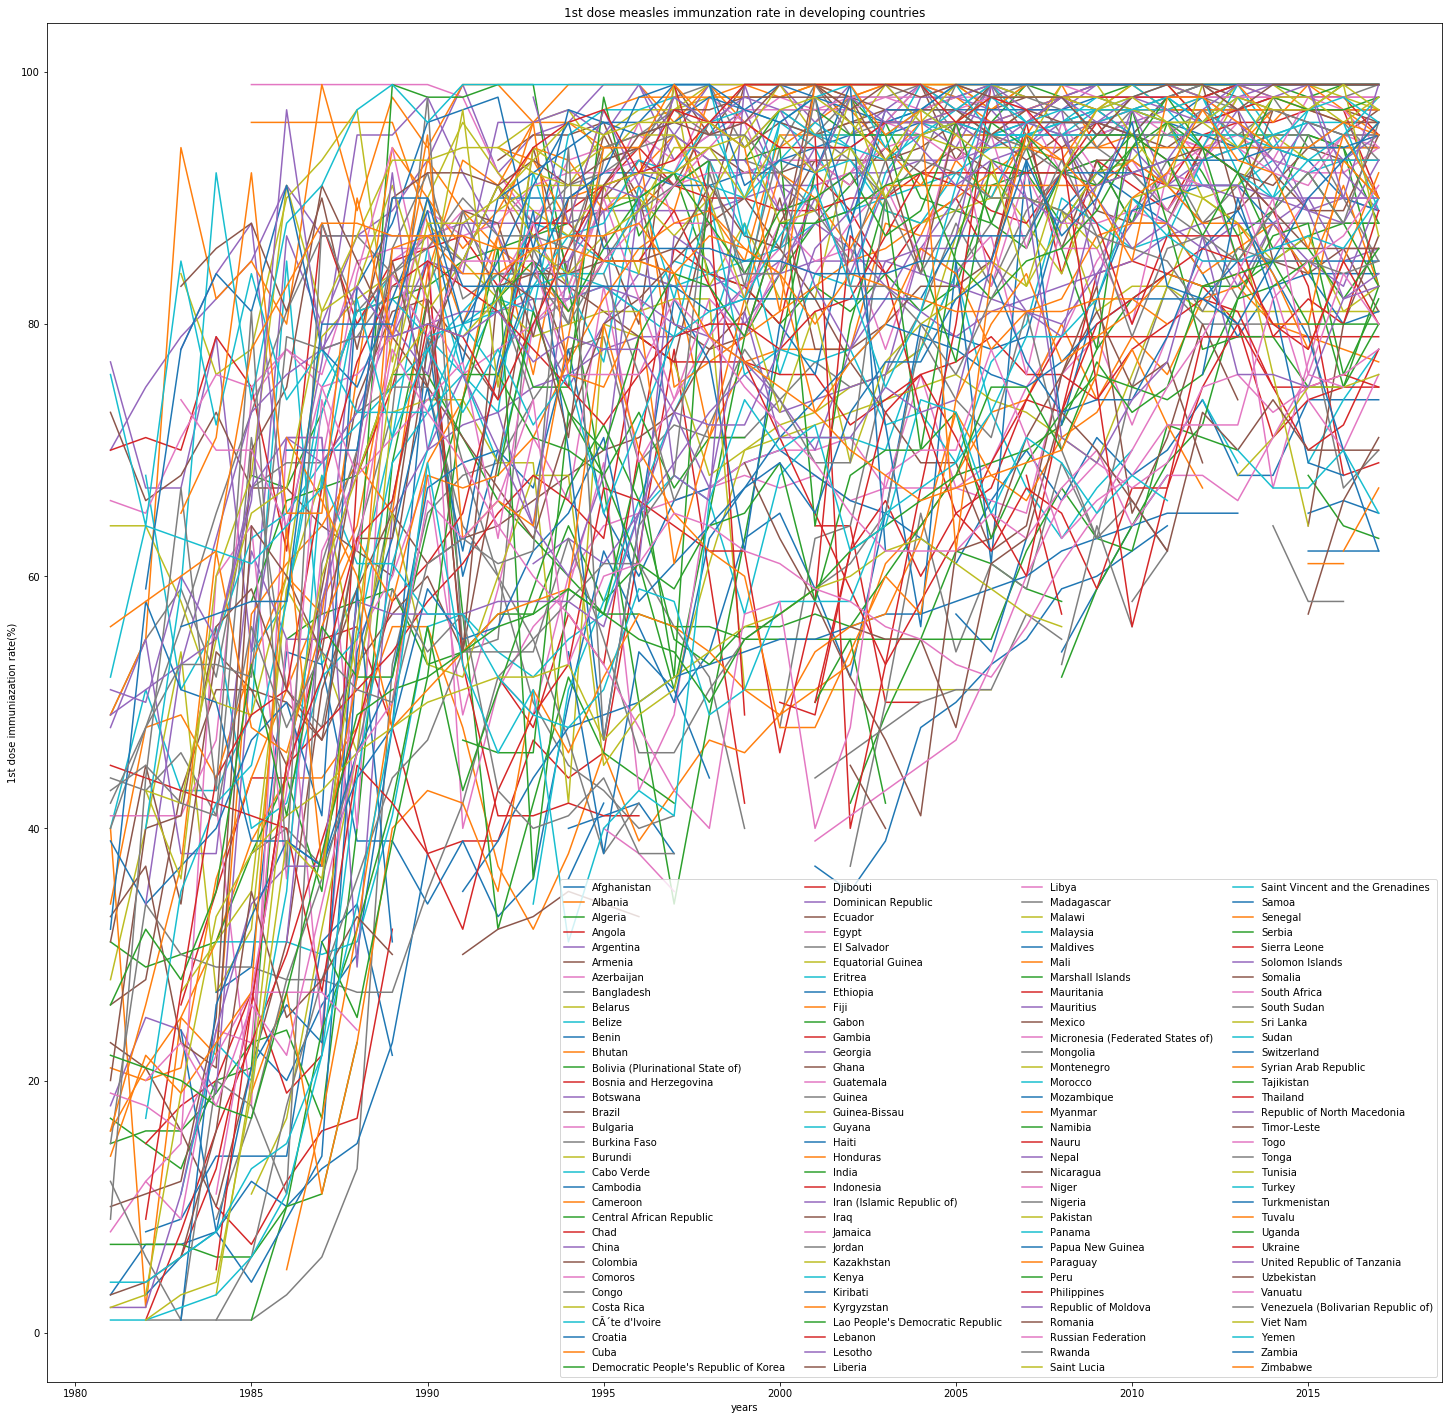

In [48]:
#scatter plot for developing countries
developingimmune.T.plot(figsize=(25,25))
plt.ylabel('1st dose immuniazation rate(%)')
plt.xlabel('years')
plt.title('1st dose measles immunzation rate in developing countries')
plt.legend(ncol=4, loc=4)